In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy
from scipy import optimize
import os
import sys
import csv
import math
import time
import re
import pickle

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD
from tensorflow.random import set_seed
from tensorflow.keras import backend as K
from keras.layers.preprocessing import preprocessing_utils

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/sdes')
import sde_solve
import sde_systems

sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/systems')
import rabi_weak_meas

sys.path.append('/content/gdrive/MyDrive/git/quantumML/python/models')
import fusion
import flex

In [4]:
import imp
imp.reload(fusion)
imp.reload(flex)
imp.reload(sde_systems)

<module 'sde_systems' from '/content/gdrive/MyDrive/git/quantumML/python/sdes/sde_systems.py'>

# Data Preprocessing

In [ ]:
# Load large dataset averaged over 10 runs
mint = 0
maxt = 4.0
deltat = 2**(-8)
tvec = np.arange(mint,maxt,deltat)

voltage_dir = '/content/gdrive/MyDrive/Research/QML/models/eps_ZZ00_grp1000_N40_T4_avg10/voltage'
all_probs_dir = '/content/gdrive/MyDrive/Research/QML/models/eps_ZZ00_grp1000_N40_T4_avg10/all_probs'
epsilons_dir = '/content/gdrive/MyDrive/Research/QML/models/eps_ZZ00_grp1000_N40_T4_avg10/epsilons'
voltage = tf.saved_model.load(voltage_dir)
all_probs = tf.saved_model.load(all_probs_dir)
epsilons = tf.cast(tf.saved_model.load(epsilons_dir), dtype=all_probs.dtype)

In [ ]:
# Append true parameter values to probability tensor
all_probs = tf.concat([all_probs, tf.tile(epsilons[:,tf.newaxis,tf.newaxis], multiples=[1,all_probs.shape[1],1])], axis=2)

# Take the average voltage records over groups
voltage = tf.reduce_mean(voltage, axis=1)[...,tf.newaxis]

# Compute the voltage centered differences
voltage_diff = (voltage[:,2:,...] - voltage[:,:-2,...])/(2.0*deltat)
all_probs = all_probs[:,1:-1,:]
tvec = tvec[1:-1]

In [ ]:
# Split the derivatives
train_frac = 0.5
train_x, valid_x, train_y, valid_y = fusion.split_data(voltage_diff.numpy(), all_probs.numpy(), train_frac)
_, _, train_params, valid_params = fusion.split_data(voltage_diff.numpy(), all_probs[...,-1,-1].numpy(), train_frac)

In [ ]:
# Keep the real parts of the data only
train_x = np.real(train_x)
train_y = np.real(train_y)
valid_x = np.real(valid_x)
valid_y = np.real(valid_y)

print(train_x.shape)
print(train_y.shape)
print(train_params.shape)
print(valid_x.shape)
print(valid_y.shape)
print(valid_params.shape)

(20, 1022, 2, 1)
(20, 1022, 43)
(20,)
(20, 1022, 2, 1)
(20, 1022, 43)
(20,)


# Train the Encoder Direct from Known Parameters

In [ ]:
# Build CNN model
_, seq_len, num_features, grp_size = train_x.shape
num_params = 1
num_epochs = 75
conv_sizes = [32]
encoder_sizes = [100, 50]
avg_size = 20

# Starting with ZZ00 initial condition
rho0 = np.zeros([4,4], dtype=float)
rho0[0,0] = 1.0

# Set the parameter values
params = np.array([1.395,2.0*0.83156,0.1469,0.1], dtype=np.double)

model = fusion.build_fusion_cnn_model(seq_len, num_features, grp_size, avg_size, conv_sizes, encoder_sizes, num_params, rho0, params, deltat)

# Remove the physical and parameter layers for this test
model.pop()
model.pop()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d (AverageP  (None, 1003, 2, 1)       0         
 ooling2D)                                                       
                                                                 
 conv2d (Conv2D)             (None, 492, 1, 32)        1312      
                                                                 
 average_pooling2d_1 (Averag  (None, 473, 1, 32)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 15136)             0         
                                                                 
 dense (Dense)               (None, 100)               1513700   
                                                                 
 dense_1 (Dense)             (None, 50)                5

In [ ]:
# Compile the model
loss_func = fusion.param_loss
fusion.compile_model(model, loss_func)

In [ ]:
# Keras train
verbose_level = 1
mini_batch_size = 20

lrscheduler = tf.keras.callbacks.LearningRateScheduler(tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-3,
    decay_steps=1,
    decay_rate=0.99))

history = model.fit(train_x, train_params[:,tf.newaxis], batch_size=mini_batch_size, epochs=num_epochs,
                    validation_data=(valid_x, valid_params[:,tf.newaxis]), verbose=verbose_level, shuffle=True,
                    callbacks=[lrscheduler])

Epoch 1/75
1/1 [==============================] - 2s 2s/step - loss: 1.3337 - val_loss: 0.9703 - lr: 0.0050
Epoch 2/75
1/1 [==============================] - 0s 193ms/step - loss: 1.0491 - val_loss: 0.2145 - lr: 0.0049
Epoch 3/75
1/1 [==============================] - 0s 208ms/step - loss: 0.2313 - val_loss: 0.4438 - lr: 0.0049
Epoch 4/75
1/1 [==============================] - 0s 219ms/step - loss: 0.4202 - val_loss: 0.1845 - lr: 0.0049
Epoch 5/75
1/1 [==============================] - 0s 184ms/step - loss: 0.1659 - val_loss: 0.0762 - lr: 0.0048
Epoch 6/75
1/1 [==============================] - 0s 162ms/step - loss: 0.0766 - val_loss: 0.1811 - lr: 0.0048
Epoch 7/75
1/1 [==============================] - 0s 174ms/step - loss: 0.1940 - val_loss: 0.0802 - lr: 0.0047
Epoch 8/75
1/1 [==============================] - 0s 184ms/step - loss: 0.0837 - val_loss: 0.0282 - lr: 0.0047
Epoch 9/75
1/1 [==============================] - 0s 186ms/step - loss: 0.0220 - val_loss: 0.0980 - lr: 0.0046
Epoc

1/1 [==============================] - 0s 37ms/step


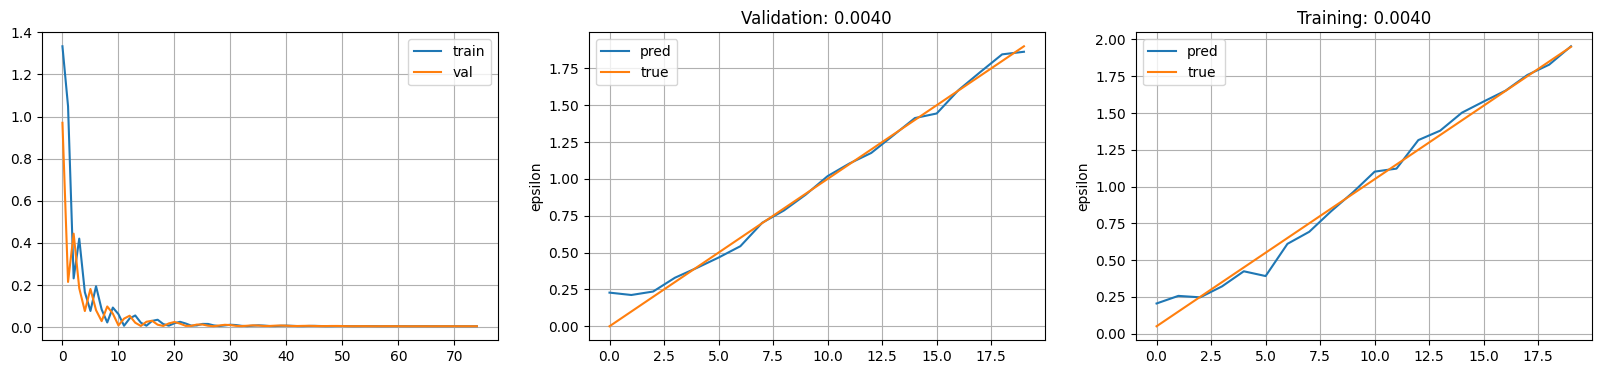

In [ ]:
# Plot the results
plt.figure(figsize=(20,4))

plt.subplot(1,3,1)

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.grid();

plt.subplot(1,3,2)
model_out = model.predict(valid_x)
plt.plot(model_out + 1.0e-8, label='pred');
plt.plot(valid_params, label='true')
plt.grid()
plt.legend()
plt.title('Validation: %.4f' % (fusion.param_loss(valid_params[:,tf.newaxis], model_out).numpy()))
plt.ylabel('epsilon');

plt.subplot(1,3,3)
model_out = model.predict(train_x)
plt.plot(model_out + 1.0e-8, label='pred');
plt.plot(train_params, label='true')
plt.grid();
plt.legend()
plt.title('Training: %.4f' % (fusion.param_loss(train_params[:,tf.newaxis], model_out).numpy()))
plt.ylabel('epsilon');

# Train Using Strong Measurement Probabilities

In [ ]:
# Build CNN model
_, seq_len, num_features, grp_size = train_x.shape
num_params = 1
num_epochs = 75
conv_sizes = [32]
encoder_sizes = [100, 50]
avg_size = 20

# Starting with ZZ00 initial condition
rho0 = np.zeros([4,4], dtype=float)
rho0[0,0] = 1.0

# Set the parameter values
params = np.array([1.395,2.0*0.83156,0.1469,0.1], dtype=np.double)

model = fusion.build_fusion_cnn_model(seq_len, num_features, grp_size, avg_size, conv_sizes, encoder_sizes, num_params, rho0, params, deltat)

model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d_8 (Averag  (None, 1003, 2, 1)       0         
 ePooling2D)                                                     
                                                                 
 conv2d_4 (Conv2D)           (None, 492, 1, 32)        1312      
                                                                 
 average_pooling2d_9 (Averag  (None, 473, 1, 32)       0         
 ePooling2D)                                                     
                                                                 
 flatten_4 (Flatten)         (None, 15136)             0         
                                                                 
 dense_8 (Dense)             (None, 100)               1513700   
                                                                 
 dense_9 (Dense)             (None, 50)               

In [ ]:
# Compile the model
loss_func = fusion.fusion_mse_loss_2d
metric_func = fusion.param_metric
fusion.compile_model(model, loss_func, metrics=[metric_func])

1/1 [==============================] - 25s 25s/step


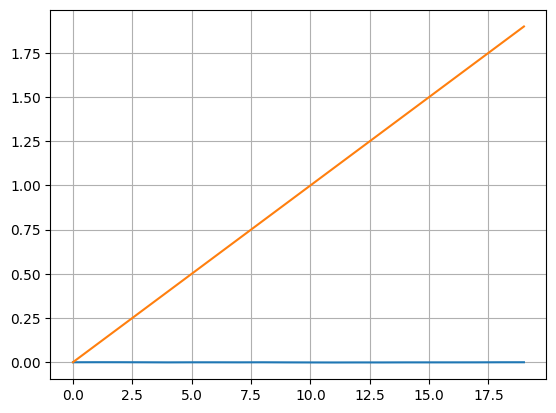

In [ ]:
# View initial parameters
model_out = model.predict(valid_x)
plt.plot(model_out[:,0,-1] + 1.0e-8)
plt.plot(valid_params)
plt.grid();

In [ ]:
print('Initial validation loss: %.5f' % (loss_func(valid_y, model_out)))
print('Initial validation metric: %.5f' % (metric_func(valid_y, model_out)))

Initial validation loss: 0.00535
Initial validation metric: 1.11225


-0.0005035400390625


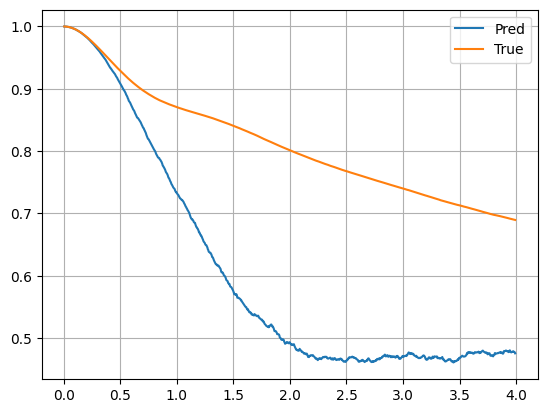

In [ ]:
# View initial probability as a sanity check
plt.plot(tvec, model_out[-1,:,4], label='Pred')
plt.plot(tvec, valid_y[-1,:,4], label='True')
plt.legend()
plt.grid();
print(model_out[-1,-1,-1])

In [ ]:
# Keras train
verbose_level = 1
mini_batch_size = 20
num_epochs = 75

lrscheduler = tf.keras.callbacks.LearningRateScheduler(tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-3,
    decay_steps=1,
    decay_rate=0.99))

history = model.fit(train_x, train_y, batch_size=mini_batch_size, epochs=num_epochs,
                    validation_data=(valid_x, valid_y), verbose=verbose_level, shuffle=True,
                    callbacks=[lrscheduler])

Epoch 1/75
1/1 [==============================] - 116s 116s/step - loss: 0.0057 - param_metric: 1.1553 - val_loss: 0.0054 - val_param_metric: 1.0809 - lr: 0.0050
Epoch 2/75
1/1 [==============================] - 35s 35s/step - loss: 0.0056 - param_metric: 1.1233 - val_loss: 0.0049 - val_param_metric: 0.9927 - lr: 0.0049
Epoch 3/75
1/1 [==============================] - 38s 38s/step - loss: 0.0051 - param_metric: 1.0329 - val_loss: 0.0033 - val_param_metric: 0.7573 - lr: 0.0049
Epoch 4/75
1/1 [==============================] - 38s 38s/step - loss: 0.0036 - param_metric: 0.7905 - val_loss: 7.7505e-04 - val_param_metric: 0.3480 - lr: 0.0049
Epoch 5/75
1/1 [==============================] - 38s 38s/step - loss: 8.3893e-04 - param_metric: 0.3489 - val_loss: 0.0033 - val_param_metric: 0.8237 - lr: 0.0048
Epoch 6/75
1/1 [==============================] - 36s 36s/step - loss: 0.0035 - param_metric: 0.8001 - val_loss: 0.0026 - val_param_metric: 0.6955 - lr: 0.0048
Epoch 7/75
1/1 [==============

1/1 [==============================] - 9s 9s/step


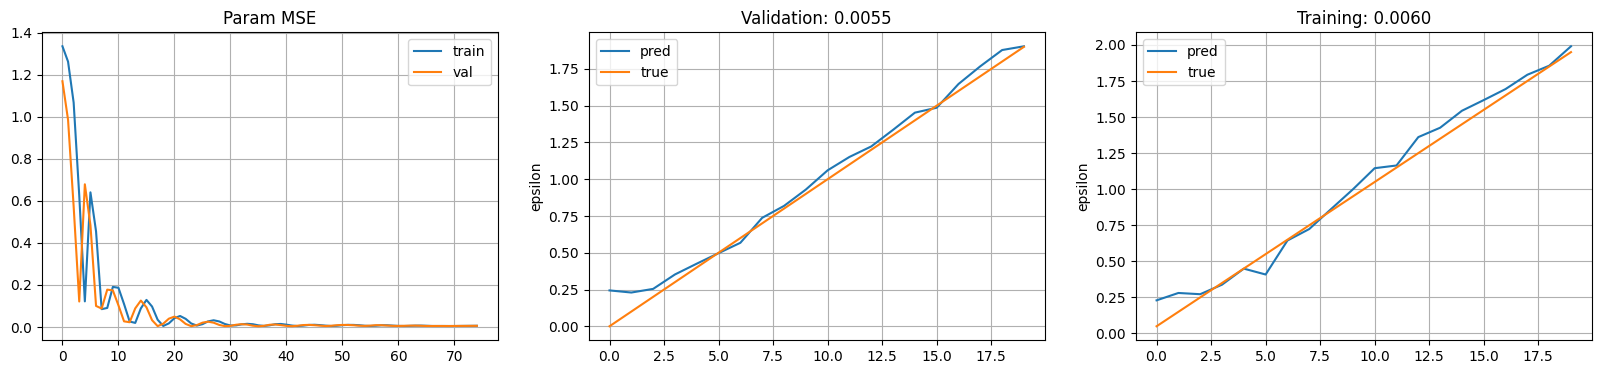

In [ ]:
# Plot the results
plt.figure(figsize=(20,4))

plt.subplot(1,3,1)

plt.plot(np.array(history.history['param_metric'])**2, label='train')
plt.plot(np.array(history.history['val_param_metric'])**2, label='val')
plt.legend()
plt.title('Param MSE')
plt.grid();

plt.subplot(1,3,2)
model_out = model.predict(valid_x)
plt.plot(model_out[:,-1,-1] + 1.0e-8, label='pred');
plt.plot(valid_params, label='true')
plt.grid()
plt.legend()
plt.title('Validation: %.4f' % (fusion.param_loss(valid_params[:,tf.newaxis], model_out[:,-1,-1][:,tf.newaxis] + 1.0e-8).numpy()))
plt.ylabel('epsilon');

plt.subplot(1,3,3)
model_out = model.predict(train_x)
plt.plot(model_out[:,-1,-1] + 1.0e-8, label='pred');
plt.plot(train_params, label='true')
plt.grid();
plt.legend()
plt.title('Training: %.4f' % (fusion.param_loss(train_params[:,tf.newaxis], model_out[:,-1,-1][:,tf.newaxis] + 1.0e-8).numpy()))
plt.ylabel('epsilon');

# Test Flex Model

In [5]:
# Load large dataset averaged over 10 runs
mint = 0
maxt = 4.0
deltat = 2**(-8)
tvec = np.arange(mint,maxt,deltat)

voltage_dir = '/content/gdrive/MyDrive/Research/QML/models/eps_ZZ00_grp1000_N40_T4_avg10/voltage'
all_probs_dir = '/content/gdrive/MyDrive/Research/QML/models/eps_ZZ00_grp1000_N40_T4_avg10/all_probs'
epsilons_dir = '/content/gdrive/MyDrive/Research/QML/models/eps_ZZ00_grp1000_N40_T4_avg10/epsilons'
voltage = tf.saved_model.load(voltage_dir)
all_probs = tf.saved_model.load(all_probs_dir)
epsilons = tf.cast(tf.saved_model.load(epsilons_dir), dtype=all_probs.dtype)

In [6]:
# Append true parameter values to probability tensor
all_probs = tf.concat([all_probs, tf.tile(epsilons[:,tf.newaxis,tf.newaxis], multiples=[1,all_probs.shape[1],1])], axis=2)

In [7]:
# Subsample in time
voltage = voltage[:,:,::2,...]
all_probs = all_probs[:,::2,:]

mint = 0
maxt = 4.0
deltat = 2**(-8)*2
tvec = np.arange(mint,maxt,deltat)

In [8]:
# Take the average voltage records over groups
voltage = tf.reduce_mean(voltage, axis=1)[...,tf.newaxis]

In [9]:
# Compute the voltage centered differences
voltage_diff = (voltage[:,2:,...] - voltage[:,:-2,...])/(2.0*deltat)
all_probs = all_probs[:,1:-1,:]
tvec = tvec[1:-1]

In [10]:
# Split the derivatives
train_frac = 0.5
train_x, valid_x, train_y, valid_y = fusion.split_data(voltage_diff.numpy(), all_probs.numpy(), train_frac)
_, _, train_params, valid_params = fusion.split_data(voltage_diff.numpy(), all_probs[...,-1,-1].numpy(), train_frac)

In [11]:
# Keep the real parts of the data only
train_x = np.real(train_x)
train_y = np.real(train_y)
valid_x = np.real(valid_x)
valid_y = np.real(valid_y)

orig_train_y = train_y
orig_valid_y = valid_y

print(train_x.shape)
print(train_y.shape)
print(train_params.shape)
print(valid_x.shape)
print(valid_y.shape)
print(valid_params.shape)

(20, 510, 2, 1)
(20, 510, 43)
(20,)
(20, 510, 2, 1)
(20, 510, 43)
(20,)


In [12]:
# Reduce number of strong measurement points
stride = 64
train_y = tf.concat([orig_train_y[:,::stride,...], orig_train_y[:,-1,tf.newaxis,...]], axis=1)
valid_y = tf.concat([orig_valid_y[:,::stride,...], orig_valid_y[:,-1,tf.newaxis,...]], axis=1)
print(train_y.shape)
print(valid_y.shape)

(20, 9, 43)
(20, 9, 43)


In [13]:
# Build CNN model
_, seq_len, num_features, grp_size = train_x.shape
num_params = 1
conv_sizes = [32]
encoder_sizes = [100, 50]
lstm_size = 10
avg_size = 20

# Starting with ZZ00 initial condition
sx, sy, sz = sde_systems.paulis()
rho0 = sde_systems.get_init_rho(sz, sz, 0, 0)

# Set the parameter values (with an omega error)
params = np.array([1.0,2.0*0.6,0.1469,0.1], dtype=np.double)

model = flex.build_full_flex_model(seq_len, num_features, grp_size, avg_size, conv_sizes, encoder_sizes, lstm_size, num_params, rho0, params, deltat)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 average_pooling2d (AverageP  (None, 491, 2, 1)        0         
 ooling2D)                                                       
                                                                 
 conv2d (Conv2D)             (None, 236, 1, 32)        1312      
                                                                 
 average_pooling2d_1 (Averag  (None, 217, 1, 32)       0         
 ePooling2D)                                                     
                                                                 
 flatten (Flatten)           (None, 6944)              0         
                                                                 
 dense (Dense)               (None, 100)               694500    
                                                                 
 dense_1 (Dense)             (None, 50)                5

In [14]:
loss_func = fusion.fusion_mse_loss_single
metric_func = fusion.param_metric
fusion.compile_model(model, loss_func, metrics=[metric_func])

In [15]:
model_out = model.predict(valid_x)
print('Initial validation loss: %.5f' % (loss_func(valid_y, model_out)))

1/1 [==============================] - 21s 21s/step
Initial validation loss: 0.00718


In [16]:
print('Initial validation MSE: %.5f' % (metric_func(valid_y, model_out)**2))

Initial validation MSE: 1.22766


In [17]:
fusion.fusion_mse_loss_2d(orig_valid_y, model_out)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0047192015>

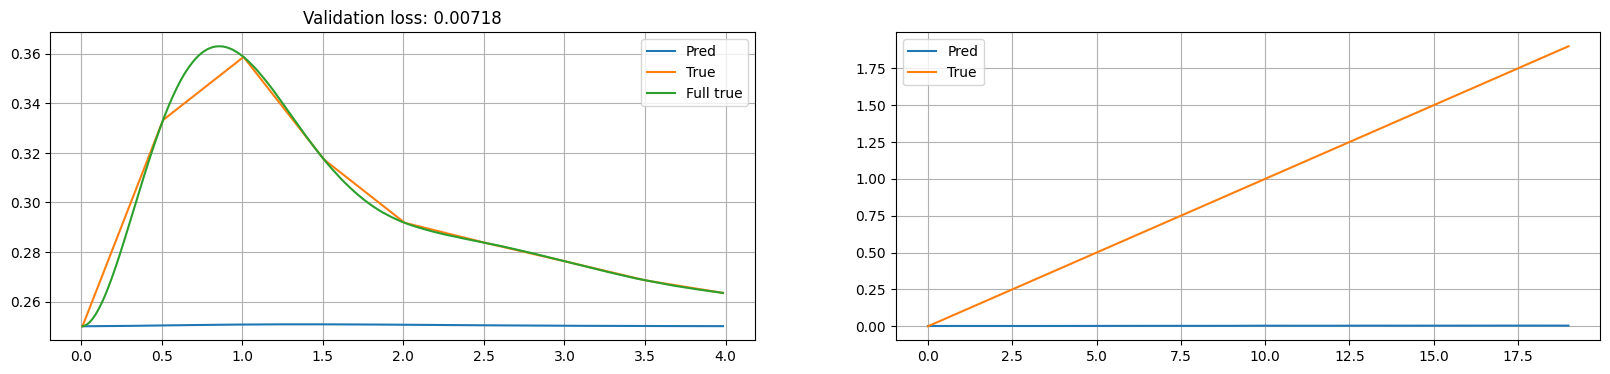

In [18]:
plt.figure(figsize=(20,4))

plt.subplot(1,2,1)
idx = 10
prob_idx = 6
plt.plot(tvec, model_out[idx, :, prob_idx], label='Pred')
plt.plot(tf.concat([tvec[::stride], tvec[-1,tf.newaxis]], axis=0), valid_y[idx, :, prob_idx], label='True')
plt.plot(tvec, orig_valid_y[idx, :, prob_idx], label='Full true')
plt.title('Validation loss: %.5f' % (loss_func(valid_y, model_out)))
plt.legend()
plt.grid();

plt.subplot(1,2,2)
plt.plot(model_out[:,-1,-1], label='Pred')
plt.plot(valid_params, label='True')
plt.legend()
plt.grid();

In [19]:
# Keras train
verbose_level = 1
mini_batch_size = 10
num_epochs = 50

# Set which layers are trainable
#train_decoder = False
#for layer in model.layers:
#  layer.trainable = not train_decoder
  #layer.trainable = True
#model.layers[-1].trainable = train_decoder
#model.layers[-1].cell.trainable = train_decoder
#model.layers[-1].cell.flex.a_cell_real.trainable = train_decoder
#model.layers[-1].cell.flex.a_cell_imag.trainable = train_decoder
#model.layers[-1].cell.flex.b_cell_real.trainable = train_decoder
#model.layers[-1].cell.flex.b_cell_imag.trainable = train_decoder

#fusion.compile_model(model, loss_func, metrics=[metric_func])

lrscheduler = tf.keras.callbacks.LearningRateScheduler(tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-3,
    decay_steps=1,
    decay_rate=0.95))

history = model.fit(train_x, train_y, batch_size=mini_batch_size, epochs=num_epochs,
                    validation_data=(valid_x, valid_y), verbose=verbose_level, shuffle=True,
                    callbacks=[lrscheduler])

Epoch 1/50


2/2 [==============================] - 85s 34s/step - loss: 0.0067 - param_metric: 1.1286 - val_loss: 0.0042 - val_param_metric: 0.8344 - lr: 0.0050
Epoch 2/50
2/2 [==============================] - 34s 22s/step - loss: 0.0030 - param_metric: 0.8082 - val_loss: 0.0037 - val_param_metric: 0.3036 - lr: 0.0047
Epoch 3/50
2/2 [==============================] - 31s 21s/step - loss: 0.0032 - param_metric: 0.2925 - val_loss: 0.0020 - val_param_metric: 0.3169 - lr: 0.0045
Epoch 4/50
2/2 [==============================] - 32s 20s/step - loss: 0.0017 - param_metric: 0.4166 - val_loss: 0.0018 - val_param_metric: 0.5088 - lr: 0.0043
Epoch 5/50
2/2 [==============================] - 36s 22s/step - loss: 0.0020 - param_metric: 0.6048 - val_loss: 0.0020 - val_param_metric: 0.5183 - lr: 0.0041
Epoch 6/50
2/2 [==============================] - 31s 22s/step - loss: 0.0020 - param_metric: 0.5522 - val_loss: 0.0016 - val_param_metric: 0.3677 - lr: 0.0039
Epoch 7/50
2/2 [==============================] - 3

In [20]:
valid_y.shape

TensorShape([20, 9, 43])

In [21]:
pmetric = []
vpmetric = []
tloss = []
vloss = []
pmetric += history.history['param_metric']
vpmetric += history.history['val_param_metric']
tloss += history.history['loss']
vloss += history.history['val_loss']

In [22]:
# Reset LR and train again
verbose_level = 1
mini_batch_size = 10
num_epochs = 50

lrscheduler = tf.keras.callbacks.LearningRateScheduler(tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=5e-3,
    decay_steps=1,
    decay_rate=0.95))

history = model.fit(train_x, train_y, batch_size=mini_batch_size, epochs=num_epochs,
                    validation_data=(valid_x, valid_y), verbose=verbose_level, shuffle=True,
                    callbacks=[lrscheduler])

Epoch 1/50
2/2 [==============================] - 34s 22s/step - loss: 3.4938e-04 - param_metric: 0.1525 - val_loss: 3.3922e-04 - val_param_metric: 0.1164 - lr: 0.0050
Epoch 2/50
2/2 [==============================] - 34s 22s/step - loss: 3.3364e-04 - param_metric: 0.1411 - val_loss: 3.3003e-04 - val_param_metric: 0.1057 - lr: 0.0047
Epoch 3/50
2/2 [==============================] - 34s 22s/step - loss: 3.1600e-04 - param_metric: 0.1328 - val_loss: 3.1366e-04 - val_param_metric: 0.1169 - lr: 0.0045
Epoch 4/50
2/2 [==============================] - 35s 23s/step - loss: 3.1335e-04 - param_metric: 0.1573 - val_loss: 3.0219e-04 - val_param_metric: 0.1058 - lr: 0.0043
Epoch 5/50
2/2 [==============================] - 34s 22s/step - loss: 2.9394e-04 - param_metric: 0.1291 - val_loss: 3.1204e-04 - val_param_metric: 0.0859 - lr: 0.0041
Epoch 6/50
2/2 [==============================] - 32s 20s/step - loss: 2.9222e-04 - param_metric: 0.1157 - val_loss: 2.8799e-04 - val_param_metric: 0.1088 - lr:

In [23]:
pmetric += history.history['param_metric']
vpmetric += history.history['val_param_metric']
tloss += history.history['loss']
vloss += history.history['val_loss']

1/1 [==============================] - 7s 7s/step


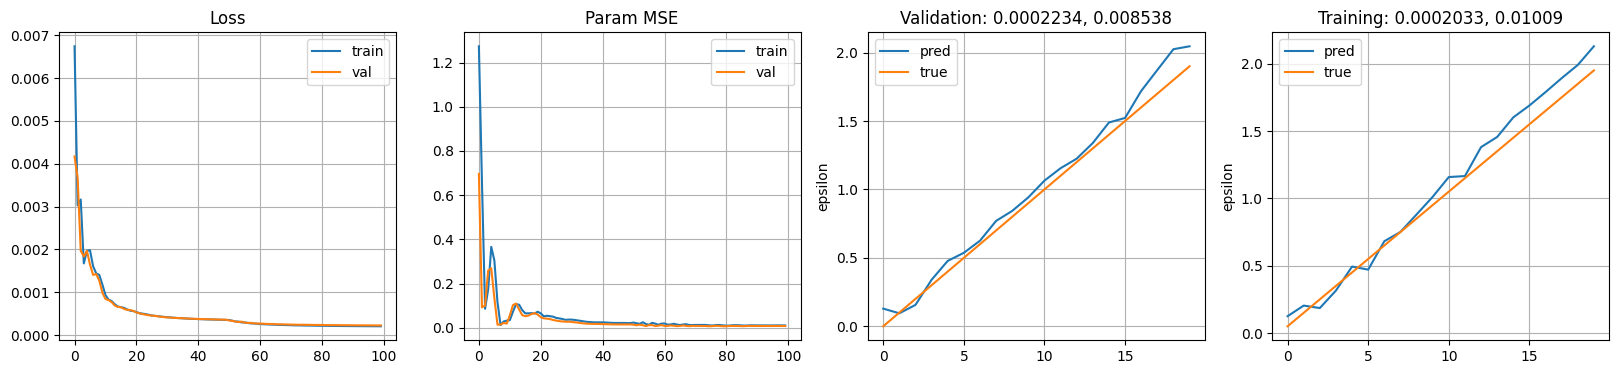

In [24]:
# Plot the results
plt.figure(figsize=(20,4))

plt.subplot(1,4,1)

plt.plot(tloss, label='train')
plt.plot(vloss, label='val')
plt.legend()
plt.title('Loss')
plt.grid();

plt.subplot(1,4,2)

plt.plot(np.array(pmetric)**2, label='train')
plt.plot(np.array(vpmetric)**2, label='val')
plt.legend()
plt.title('Param MSE')
plt.grid();

plt.subplot(1,4,3)
model_out = model.predict(valid_x)
plt.plot(model_out[:,-1,-1] + 1.0e-8, label='pred');
plt.plot(valid_params, label='true')
plt.grid()
plt.legend()
plt.title('Validation: %.4g, %.4g' % (loss_func(valid_y, model_out).numpy(), metric_func(valid_y, model_out).numpy()**2))
plt.ylabel('epsilon');

plt.subplot(1,4,4)
model_out = model.predict(train_x)
plt.plot(model_out[:,-1,-1] + 1.0e-8, label='pred');
plt.plot(train_params, label='true')
plt.grid();
plt.legend()
plt.title('Training: %.4g, %.4g' % (loss_func(train_y, model_out).numpy(), metric_func(train_y, model_out).numpy()**2))
plt.ylabel('epsilon');

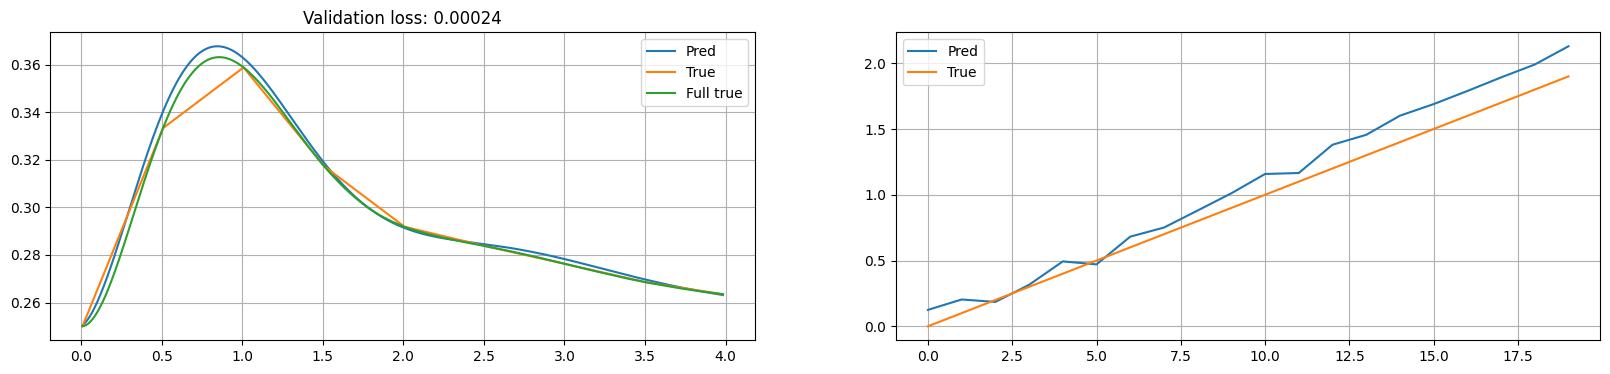

In [25]:
plt.figure(figsize=(20,4))

plt.subplot(1,2,1)
idx = 10
prob_idx = 6
plt.plot(tvec, model_out[idx, :, prob_idx], label='Pred')
plt.plot(tf.concat([tvec[::stride], tvec[-1,tf.newaxis]], axis=0), valid_y[idx, :, prob_idx], label='True')
plt.plot(tvec, orig_valid_y[idx, :, prob_idx], label='Full true')
plt.title('Validation loss: %.5f' % (loss_func(valid_y, model_out)))
plt.legend()
plt.grid();

plt.subplot(1,2,2)
plt.plot(model_out[:,-1,-1], label='Pred')
plt.plot(valid_params, label='True')
plt.legend()
plt.grid();

In [26]:
model_out = model.predict(valid_x)
print('Final validation loss: %.5f' % (loss_func(valid_y, model_out)))

1/1 [==============================] - 7s 7s/step
Final validation loss: 0.00022


In [27]:
print('Final validation MSE: %.5f' % (metric_func(valid_y, model_out)**2))

Final validation MSE: 0.00854


In [28]:
fusion.fusion_mse_loss_2d(orig_valid_y, model_out)

<tf.Tensor: shape=(), dtype=float32, numpy=0.0002869366>